In [179]:
import pandas as pd
from darts import TimeSeries
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer



import warnings
warnings.filterwarnings("ignore")

def fix_datetime(X, name):
    """
    Function to fix and standardize datetime in the given DataFrame.
    
    Parameters:
    - X: DataFrame to be modified.
    - name: String representing the name of the DataFrame, used for logging.
    
    Returns:
    - Modified DataFrame with standardized datetime.
    """

    # Convert 'date_forecast' to datetime format and replace original column with 'ds'
    X['ds'] = pd.to_datetime(X['date_forecast'])
    X.drop(columns=['date_forecast'], inplace=True, errors='ignore')

    # Sort DataFrame by the new datetime column ('ds') and set it as the index
    X.sort_values(by='ds', inplace=True)
    X.set_index('ds', inplace=True)

    # Log the shape of the DataFrame before dropping rows with in-between minutes
    print(f"Shape of {name} before dropping in-between hour rows: ", X.shape)

    # Identify and log gaps in the date sequence
    print(f"HEIHEI: {name} gaps in dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())
    print(f"HEIHEI: {name} first gap in dates: ", X[X.index.to_series().diff().dt.total_seconds().gt(60*15)==True].index[:1])

    # Calculate and log the size of each gap in the date sequence
    temp = X.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print(f"HEIHEI: {name} list of size (in days) of each gap: ", temp[temp.gt(60*15)].values / (60*60*24))
    
    # temporarily transform into darts time series to fill missing dates
    # get date_calc if date_calc is column in X
    temp_calc = None
    if "date_calc" in X.columns:
        temp_calc = X["date_calc"]
        X.drop(columns=['date_calc'], inplace=True)
    X = TimeSeries.from_dataframe(df=X, freq="15T", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    if temp_calc is not None:
        X["date_calc"] = temp_calc

    print(f"HEIHEI: {name} gaps in dates after filling missing dates: ", X.index.to_series().diff().dt.total_seconds().gt(60*15).sum())


    # Drop rows where the minute part of the time is not 0
    X = X[X.index.minute == 0]

    # Log the shape of the DataFrame after dropping rows with in-between minutes
    print(f"Shape of {name} after dropping in-between hour rows: ", X.shape)

    return X



def convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train):
    X_train_observed = fix_datetime(X_train_observed, "X_train_observed")
    X_train_estimated = fix_datetime(X_train_estimated, "X_train_estimated")
    X_test = fix_datetime(X_test, "X_test")


    X_train_observed["estimated_diff_hours"] = 0
    X_train_estimated["estimated_diff_hours"] = (X_train_estimated.index - pd.to_datetime(X_train_estimated["date_calc"])).dt.total_seconds() / 3600.0
    X_test["estimated_diff_hours"] = (X_test.index - pd.to_datetime(X_test["date_calc"])).dt.total_seconds() / 3600.0

    X_train_estimated.drop(columns=['date_calc'], inplace=True)
    X_test.drop(columns=['date_calc'], inplace=True)

    y_train['ds'] = pd.to_datetime(y_train['time'])
    y_train.drop(columns=['time'], inplace=True)
    y_train.sort_values(by='ds', inplace=True)
    y_train.set_index('ds', inplace=True)

    return X_train_observed, X_train_estimated, X_test, y_train




# location_map = {
#     "A": 0,
#     "B": 1,
#     "C": 2
# }


def preprocess_data(X_train_observed, X_train_estimated, X_test, y_train, location):
    # convert to datetime
    X_train_observed, X_train_estimated, X_test, y_train = convert_to_datetime(X_train_observed, X_train_estimated, X_test, y_train)


    # # cast all columns to float64
    # X_train = X_train.astype('float64')
    # X_test = X_test.astype('float64')


    print(f"X_train_observed shape: {X_train_observed.shape}")
    print(f"X_train_estimated shape: {X_train_estimated.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")



    y_train["y"] = y_train["pv_measurement"].astype('float64')
    y_train.drop(columns=['pv_measurement'], inplace=True)
    print("y_train columns: ", y_train.columns)

    # temporarily transform into darts time series to fill missing dates
    print("Shape of y_train before filling missing dates: ", y_train.shape)
    y_train = TimeSeries.from_dataframe(df=y_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("Shape of y_train after filling missing dates: ", y_train.shape)


    # number of gaps in X_train_observed + X_train_estimated before
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated before: ", X_train_observed.index.to_series().diff().dt.total_seconds().gt(3600).sum() + X_train_estimated.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    X_train = pd.concat([X_train_observed, X_train_estimated])
    print(f"LOOK: Number of gaps in X_train_observed plus number of gaps in X_train_estimated after: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    # print size of gaps in X_train
    temp = X_train.index.to_series().diff().dt.total_seconds()
    if temp.shape[0] > 0:
        print("LOOK: list of size (in days) of each gap: ", temp[temp.gt(3600)].values / (60*60*24))
    print("if the number is bigger after than before that means there is a gap in time between the observed and estimated training sets")

    # print info on dates in X_train, and if there are any missing dates
    print("X_train dates info: ", X_train.index.min(), X_train.index.max(), X_train.index.max() - X_train.index.min())
    print("X_test dates info: ", X_test.index.min(), X_test.index.max(), X_test.index.max() - X_test.index.min())
    print("y_train dates info: ", y_train.index.min(), y_train.index.max(), y_train.index.max() - y_train.index.min())

    # any gaps in dates?
    print("X_train gaps in dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("y_train gaps in dates: ", y_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    # temporarily transform into darts time series to fill missing dates
    X_train = TimeSeries.from_dataframe(df=X_train, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    X_test = TimeSeries.from_dataframe(df=X_test, freq="H", fill_missing_dates=True, fillna_value=None).pd_dataframe()
    print("X_train gaps in dates after filling missing dates: ", X_train.index.to_series().diff().dt.total_seconds().gt(3600).sum())
    print("X_test gaps in dates after filling missing dates: ", X_test.index.to_series().diff().dt.total_seconds().gt(3600).sum())

    

    # clip all y values to 0 if negative
    y_train["y"] = y_train["y"].clip(lower=0)
    
    # print Number of missing values in X train
    print("Number of missing values in X_train: ", X_train.isnull().sum().sum())
    print("Number of missing values in X_test: ", X_test.isnull().sum().sum())
    # y_train missing values
    print("Number of missing values in y_train: ", y_train.isnull().sum().sum())
    X_train = pd.merge(X_train, y_train, how="outer", left_index=True, right_index=True)
    print("Number of missing values in X_train after merging with y_train: ", X_train.drop(columns=['y']).isnull().sum().sum())



    X_train["location"] = location
    X_test["location"] = location
    
    return X_train, X_test
    


# Define locations
locations = ['A', 'B', 'C']

X_trains = []
X_tests = []
y_trains = []
# Loop through locations
for loc in locations:
    print("\n\n")
    print(f"Processing location {loc}...")
    # Read target training data
    y_train = pd.read_parquet(f'{loc}/train_targets.parquet')
    
    # Read estimated training data and add location feature
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    
    # Read observed training data and add location feature
    X_train_observed= pd.read_parquet(f'{loc}/X_train_observed.parquet')

    # Read estimated test data and add location feature
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Concatenate observed and estimated datasets for each location
    #X_train = pd.concat([X_train_estimated, X_train_observed])
    



    # Preprocess data
    X_train, X_test = preprocess_data(X_train_observed, X_train_estimated, X_test_estimated, y_train, loc)

    print(f"Final shape of X_train for location {loc}: ", X_train.shape)
    print(f"Final shape of X_test for location {loc}: ", X_test.shape)

    # print(y_train.head(), y_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(X_train.head(), X_train.shape)
    # print(type(X_train['y']))

    # Save data to csv
    X_train.to_csv(f'{loc}/X_train.csv', index=True)
    X_test.to_csv(f'{loc}/X_test.csv', index=True)


    X_trains.append(X_train)
    X_tests.append(X_test)

# Concatenate all data and save to csv
X_train = pd.concat(X_trains)
X_test = pd.concat(X_tests)

print(f"Final shape of X_train: ", X_train.shape)
print(f"Final shape of X_test: ", X_test.shape)

X_train.to_csv('X_train_raw.csv', index=True)
X_test.to_csv('X_test_raw.csv', index=True)





        





Processing location A...
Shape of X_train_observed before dropping in-between hour rows:  (118669, 45)
HEIHEI: X_train_observed gaps in dates:  0
HEIHEI: X_train_observed first gap in dates:  DatetimeIndex([], dtype='datetime64[us]', name='ds', freq=None)
HEIHEI: X_train_observed list of size (in days) of each gap:  []
HEIHEI: X_train_observed gaps in dates after filling missing dates:  0
Shape of X_train_observed after dropping in-between hour rows:  (29668, 45)
Shape of X_train_estimated before dropping in-between hour rows:  (17576, 46)
HEIHEI: X_train_estimated gaps in dates:  0
HEIHEI: X_train_estimated first gap in dates:  DatetimeIndex([], dtype='datetime64[us]', name='ds', freq=None)
HEIHEI: X_train_estimated list of size (in days) of each gap:  []
HEIHEI: X_train_estimated gaps in dates after filling missing dates:  0
Shape of X_train_estimated after dropping in-between hour rows:  (4418, 46)
Shape of X_test before dropping in-between hour rows:  (2880, 46)
HEIHEI: X_test g

# Starting

In [180]:
import pandas as pd

df = pd.read_csv('X_train_raw.csv', index_col="ds")
df.index = pd.to_datetime(df.index)

test_df = pd.read_csv('X_test_raw.csv', index_col="ds")
test_df.index = pd.to_datetime(test_df.index)



# add sin and cos of sun_elevation:d and sun_azimuth:d
df['sin_sun_elevation'] = np.sin(np.deg2rad(df['sun_elevation:d']))
# df['sin_sun_azimuth'] = np.sin(np.deg2rad(df['sun_azimuth:d']))
# df['cos_sun_azimuth'] = np.cos(np.deg2rad(df['sun_azimuth:d']))

test_df['sin_sun_elevation'] = np.sin(np.deg2rad(test_df['sun_elevation:d']))
# test_df['sin_sun_azimuth'] = np.sin(np.deg2rad(test_df['sun_azimuth:d']))
# test_df['cos_sun_azimuth'] = np.cos(np.deg2rad(test_df['sun_azimuth:d']))

# add global_rad_1h:J = diffuse_rad_1h:J + direct_rad_1h:J
df['global_rad_1h:J'] = df['diffuse_rad_1h:J'] + df['direct_rad_1h:J']
test_df['global_rad_1h:J'] = test_df['diffuse_rad_1h:J'] + test_df['direct_rad_1h:J']

# # add t_1000hPa:K/wind_speed_10m:ms and t_1000hPa:K/global_rad_1h:J
# df['t_1000hPa:K/wind_speed_10m:ms'] = df['t_1000hPa:K'] / df['wind_speed_10m:ms']
# df['t_1000hPa:K/global_rad_1h:J'] = df['t_1000hPa:K'] / df['global_rad_1h:J']

# test_df['t_1000hPa:K/wind_speed_10m:ms'] = test_df['t_1000hPa:K'] / test_df['wind_speed_10m:ms']
# test_df['t_1000hPa:K/global_rad_1h:J'] = test_df['t_1000hPa:K'] / test_df['global_rad_1h:J']


# dew_or_rime:idx, Change this to one variable for is_dew and one variable for is_rime (dew:1, rime:-1)
df['is_dew'] = df['dew_or_rime:idx'].apply(lambda x: True if x == 1 else False)
df['is_rime'] = df['dew_or_rime:idx'].apply(lambda x: True if x == -1 else False)

test_df['is_dew'] = test_df['dew_or_rime:idx'].apply(lambda x: True if x == 1 else False)
test_df['is_rime'] = test_df['dew_or_rime:idx'].apply(lambda x: True if x == -1 else False)


# add variable for y_is_nan
# df['y_is_nan'] = df['y'].apply(lambda x: np.isnan(x))
# test_df['y_is_nan'] = 0
# df['exog_is_nan'] = df['direct_rad_1h:J'].apply(lambda x: 1 if np.isnan(x) else 0) # use this as proxy here (direct_rad_1h:J)
# test_df['exog_is_nan'] = test_df['direct_rad_1h:J'].apply(lambda x: 1 if np.isnan(x) else 0) # use this as proxy here


EXOGENOUS = [
    "is_dew",
    "is_rime",
    'estimated_diff_hours',
    "absolute_humidity_2m:gm3",
    "air_density_2m:kgm3",
    "dew_point_2m:K",
    "diffuse_rad_1h:J",
    "direct_rad_1h:J",
    "effective_cloud_cover:p",
    # "fresh_snow_1h:cm",
    "snow_depth:cm",
    "sun_elevation:d",
    "sun_azimuth:d",
    "t_1000hPa:K",
    "visibility:m",
    "wind_speed_10m:ms",
    "sin_sun_elevation",
    "global_rad_1h:J",
    ]
#additional_features_for_testing = 

df = df[EXOGENOUS + ["y", "location"]]
test_df = test_df[EXOGENOUS+ ["location"]]


# only get where location is "A"
# df = df[df["location"] == "A"]
# test_df = test_df[test_df["location"] == "A"]

# # drop location column
# df.drop(columns=['location'], inplace=True)
# test_df.drop(columns=['location'], inplace=True)


In [181]:
df.head()

,is_dew,is_rime,estimated_diff_hours,absolute_humidity_2m:gm3,air_density_2m:kgm3,dew_point_2m:K,diffuse_rad_1h:J,direct_rad_1h:J,effective_cloud_cover:p,snow_depth:cm,sun_elevation:d,sun_azimuth:d,t_1000hPa:K,visibility:m,wind_speed_10m:ms,sin_sun_elevation,global_rad_1h:J,y,location
ds,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,False,False,0.0,7.7,1.230,280.299988,0.000000,0.0,98.699997,0.0,-3.202,342.834015,285.899994,39640.101562,3.7,-0.055856,0.000000,0.00,A
2019-06-02 23:00:00,False,False,0.0,7.7,1.225,280.299988,0.000000,0.0,99.599998,0.0,-4.393,356.742004,286.799988,41699.898438,3.5,-0.076597,0.000000,0.00,A
2019-06-03 00:00:00,False,False,0.0,7.7,1.221,280.200012,0.000000,0.0,100.000000,0.0,-3.910,9.741000,287.000000,20473.000000,3.2,-0.068189,0.000000,0.00,A
2019-06-03 01:00:00,False,False,0.0,8.2,1.218,281.299988,0.000000,0.0,100.000000,0.0,-1.986,23.541000,286.899994,2104.600098,2.8,-0.034655,0.000000,0.00,A
2019-06-03 02:00:00,False,False,0.0,8.8,1.219,282.299988,7743.299805,0.0,100.000000,0.0,1.401,37.040001,286.500000,2681.600098,2.7,0.024450,7743.299805,19.36,A


In [182]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,4 hours 5 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_jorgensandhaug_s2epcx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.146 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [183]:
runs = []
max_runtime_secs = 60*60*3
max_models = None

for location, group n df.groupby("location"):
    print(f"Starting AutoML for location {location}...")
    train = h2o.H2OFrame(group.dropna(), column_types={col: "real" for col in EXOGENOUS[2:]})
    y = "y"
    x = train.columns
    x.remove(y)
    x.remove("location")

    # run aml for each location
    aml = H2OAutoML(max_runtime_secs=max_runtime_secs, max_models=max_models, seed=1)
    aml.train(x = x, y = y, training_frame = train)
    runs.append(aml)
    print(f"Finished AutoML for location {location}...")
    # bunch of newlines
    print("\n\n\n\n")

Starting AutoML for location A...
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
23:26:10.48: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████Failed polling AutoML progress log: HTTP 500 Server Error:

 (failed) 100%


OSError: Job with key $03017f00000132d4ffffffff$_b4d90ec5b91663262cdfaef204a64e7c failed with an exception: java.lang.OutOfMemoryError: Java heap space
stacktrace: 
java.lang.OutOfMemoryError: Java heap space


In [ ]:
for aml in runs:
    lb = aml.leaderboard
    m = aml.get_best_model(criterion="MAE")
    print(lb)

model_id                                                     rmse     mse      mae    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_18_20231004_232411     433.553  187969  200.636      nan                    187969
StackedEnsemble_AllModels_1_AutoML_18_20231004_232411     434.654  188924  199.193      nan                    188924
StackedEnsemble_BestOfFamily_3_AutoML_18_20231004_232411  436.76   190759  202.554      nan                    190759
StackedEnsemble_BestOfFamily_2_AutoML_18_20231004_232411  437.236  191175  200.948      nan                    191175
GBM_2_AutoML_18_20231004_232411                           437.528  191431  202.922      nan                    191431
GBM_5_AutoML_18_20231004_232411                           438.005  191849  203.951      nan                    191849
GBM_4_AutoML_18_20231004_232411                           438.581  192354  200.776      nan                    192354
StackedEnsemble_BestOfFamily_1_AutoML_18_20231004_232411

# Submit

In [ ]:
# pull in test.csv and create submission.csv
submission_ids_df = pd.read_csv('test.csv', index_col=0)
# submission_ids_df has Id, Time, Location
# X_test has location_A, location_B, location_C
# we have to make sure that submission_ids_df has same dates as X_test, then predict y for each row in submission_ids_df, then save as submission.csv (using correct Id from submission_ids_df)

# convert index to datetime
submission_ids_df["id"] = submission_ids_df.index
submission_ids_df.set_index('time', inplace=True)
submission_ids_df.index = pd.to_datetime(submission_ids_df.index).astype('datetime64[ns]')
submission_ids_df

# split submission_ids_df into each location
print(submission_ids_df.groupby('location').count())


          prediction   id
location                 
A                720  720
B                720  720
C                720  720


A
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
B
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
C
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Last submission number: 57


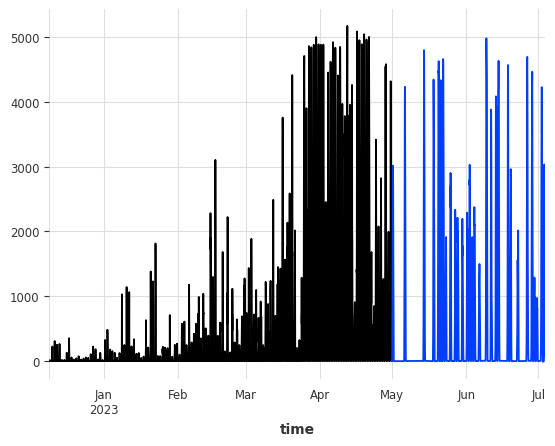

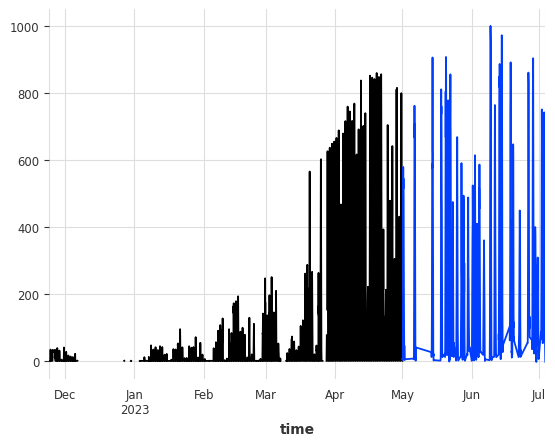

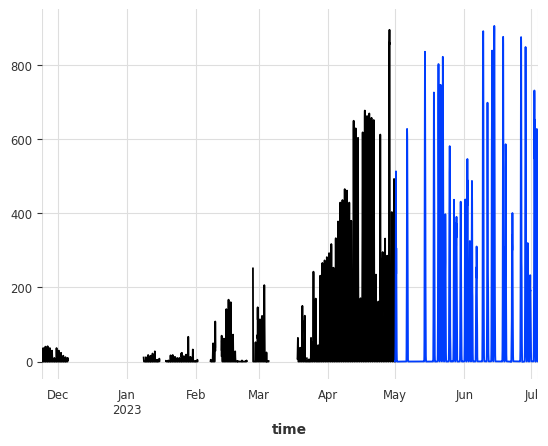

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Assuming X_test and model are already defined
# Assuming 'time' is also a datetime64[ns] column in X_test

# Initialize an empty DataFrame to store the results
submission_df = pd.DataFrame()

i = 0
# Group test by 'location' and iterate through each group
for location, group in submission_ids_df.groupby('location'):
    print(location)
    train_df = df[df["location"] == location].drop(columns=["location"])
    tdf = test_df[test_df["location"] == location].drop(columns=["location"])

    # Merge group and test_df based on the index
    merged_df = pd.merge_asof(group.sort_index(), tdf.sort_index(),
                              left_index=True, right_index=True)
                        
                
    
    h2o_frame = h2o.H2OFrame(merged_df.drop(columns=["id", "prediction", "location"]), column_types={col:"real" for col in EXOGENOUS[2:]})
    #print(h2o_frame.describe())
    m = runs[i].get_best_model(criterion="MAE")
    y = m.predict(h2o_frame)
    merged_df["y"] = y.as_data_frame().values
    
    # plot last 10% of y train together with prediction
    fig, ax = plt.subplots()
    train_df["y"].tail(int(train_df.shape[0]*0.1)).plot(ax=ax)
    merged_df["y"].plot(ax=ax)
    
    # Create a DataFrame with 'Id' and predicted values
    result_df = pd.DataFrame({
        'id': merged_df['id'],
        'prediction': merged_df['y']
    })
    
    # Append to submission DataFrame
    submission_df = pd.concat([submission_df, result_df])
    i += 1


# Save the submission DataFrame to submissions folder, create new name based on last submission, format is submission_<last_submission_number + 1>.csv
# Get the last submission number
last_submission_number = int(max([int(filename.split('_')[1].split('.')[0]) for filename in os.listdir('submissions') if "submission" in filename]))
print("Last submission number:", last_submission_number)

# Create the new filename
new_filename = f'submission_{last_submission_number + 1}.csv'

# Save the submission
submission_df.to_csv(os.path.join('submissions', new_filename), index=False)


In [ ]:
# save models
for aml in runs:
    print(aml.get_best_model(criterion="MAE").download_mojo(path="models/h2o"))

/Users/jorgensandhaug/Desktop/tdt4173/data/models/h2o/StackedEnsemble_AllModels_1_AutoML_18_20231004_232411.zip
/Users/jorgensandhaug/Desktop/tdt4173/data/models/h2o/StackedEnsemble_BestOfFamily_3_AutoML_19_20231004_232426.zip
/Users/jorgensandhaug/Desktop/tdt4173/data/models/h2o/StackedEnsemble_AllModels_1_AutoML_20_20231004_232439.zip
